# Matteo Zortea, Alessandro Rizzi  
## Brain Inspired Computing, Sheet 2  
## Group G3A8
## Exercises solved  
Ex 1: a) b)
Ex 2:
Ex 3:
Ex 4:

# Exercise 1
## a)
At time $t$ the probability of a channel beeing open is $x(t)$, hence the number of expected open channels at time $t$ is $s(t) = Nx(t)$, where $N$ is the total number of channels.  
At time $t + \Delta t$, some channels switch from opened to closed and vice-versa. This happen with the transition rates $$r_{cl \to op} = \alpha_x(u) \\ r_{op \to cl} = \beta_x(u)$$ so that the expected number of transitions from closed to opened and from opened to closed at time $t$ in a time intervals $\delta T$ are respectively $$N_{cl \to op} = (N-s(t)) \,\alpha(u) \, \Delta t = N(1-x(t)) \, \alpha(u) \, \Delta t \\ N_{op \to cl} = s(t) \, \beta(u) \, \Delta t = Nx(t) \, \beta(u) \, \Delta t$$
This means that $$s(t + \Delta t) = s(t) + N_{cl \to op} - N_{op \to cl} = s(t) + \left[ N(1-x(t)) \, \alpha(u) - Nx(t) \, \beta(u) \right] \Delta t$$
so that $$\frac{s(t+\Delta t)-s(t)}{\Delta t} = N \left[(1-x(t)) \, \alpha(u) - x(t) \, \beta(u) \right] $$
Taking the limit $\Delta t \to 0$, remembering that $s(t) = N \, x(t)$ one gets the equation for the evolution of the p.d.f. $$\frac{dx(t)}{dt} = (1-x(t)) \, \alpha(u) - x(t) \, \beta(u) = \alpha(u) - x(t) \, \left(\alpha(u) + \beta(u) \right)$$
or in short form $$\dot x = \alpha - x \left(\alpha + \beta\right) $$
## b) 
One can simply take apart $\alpha + \beta$ from the last expression
$$ \dot x = (\alpha + \beta) \left(\frac{\alpha}{\alpha + \beta} - x\right) \equiv \frac{1}{\tau} \left( x_0 - x \right)$$
so that the required transformations are $\tau = \frac{1}{\alpha + \beta}$ and $x_0 = \frac{\alpha}{\alpha + \beta}$
## c)


## Exercise 2


Parameters

In [48]:
# Parameters
dt = 0.01e-3 # ms
T_run = 300e-3 # ms
n0 = 0.3
m0 = 0.1
h0 = 0.6
u0 = -65e-3 # V

Transition rates


In [55]:
# Transition rates
#cl_to_op = lambda u: np.array([(-0.55-0.1*u*1e3)/(np.exp(-5.5-0.1*u*1e3) - 1), (-4-0.1*u*1e3)/(np.exp(-4.0-0.1*u*1e3) - 1), 0.007*np.exp(-(u*1e3+65)/20)])
def cl_to_op(u_arr):
    if isinstance(u_arr, (int, float)):
        u_arr = [u_arr]
    ret_arr = np.zeros((3, len(u_arr)))
    for i,u in enumerate(u_arr):
        if abs(-0.1*u*1e3 - 5.5) < 1e-1:
            ret_arr[0,i] = (-0.55-0.01*u*1e3)/(-0.1*u*1e3 + 5.5 + 0.5*(0.1*0.1*u*u*1e6 + 5.5*5.5 - 2*0.1*5.5*u*1e3))
        else:
            ret_arr[0,i] = (-0.55-0.1*u*1e3)/(np.exp(-5.5-0.1*u*1e3) - 1)
        ret_arr[1,i] = (-4-0.1*u*1e3)/(np.exp(-4.0-0.1*u*1e3) - 1)
        ret_arr[2,i] = 0.007*np.exp(-(u*1e3+65)/20)
    return ret_arr

op_to_cl = lambda u: np.array([0.125*np.exp(-(u*1e3+65)/80), 4.0*np.exp(-(u*1e3+65)/18), 1/(np.exp(-3.5-0.1*u*1e3) + 1)])


constants

In [56]:
# Resting potentials
E_Na = 50e-3 # V
E_K = -77e-3 # V
E_l = -54.4e-3 # V
# Conductances
g_Na = 120e-6 # S
g_K = 36e-6 # S
g_l = 0.3e-6 # S

Cm = 1e-9 # F

npoints = int(T_run/dt)

functions

In [57]:
import numpy as np 
# x0, tau
get_x0 = lambda u: cl_to_op(u)/(cl_to_op(u)+op_to_cl(u))
get_tau = lambda u: 1/(cl_to_op(u) + op_to_cl(u))

def I_ext(t):
    I = []
    for tt in t:
        n = int(tt/50e-3)
        if n%2 == 0:
            return 7.5e-9
        else:
            return 0

# Differential equations
def xdot(x, u, n):
    return (1/tau[n]) * (x0[n] - x)
def udot(u, t, n, m, h):
    y = g_l*(E_l - u) + g_Na*m**3*h*(E_Na - u) + g_K*n**4*(E_K - u) + I_ext(t)
    return y/Cm

integration

In [58]:
t = np.zeros((npoints, 1))
x = np.zeros((npoints, 3))
u = np.zeros((npoints, 1))
x_old = np.zeros((3, 1))
xdot_old = np.zeros((3,1))
u_old = 0
udot_old = 0
t[0] = 0
x[0,:] = [n0, m0, h0]
u[0] = u0
for i in range(npoints - 1):
    tau = get_tau(u[i])
    x0 = get_x0(u[i])
    
    for n in range(3):
        #xdot_old[n] = xdot(x[i,n], u[i], n)
        #x_old = x[i] + dt*x[i,n] + dt*xdot_old[n]
        x[i+1,n] = x[i,n] + dt*xdot(x[i,n], u[i], n)
    u[i+1] = u[i] + dt*udot(u[i], t[i], x[i,0], x[i,1], x[i,2])    
    #udot_old = udot(u[i], t[i], x[i,0], x[i,1], x[i,2])
    '''u[i+1] = u[i] + dt*udot(u[i], t[i], x[i,0], x[i,1], x[i,2])
    for n in range(3):
        x[i+1, n] = x_old[n] + 0.5*dt*(xdot_old[n] + xdot(x[i,n], u[i], n)) 
    u[i+1] = u[i] + 0.5*dt*(udot_old + udot(u[i], t[i], x[i,0], x[i,1], x[i,2]))'''
    t[i+1] = t[i] + dt

plotting

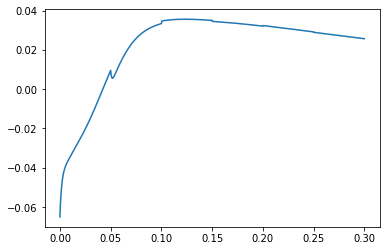

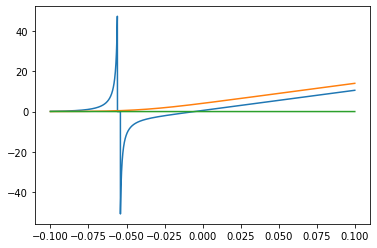

In [59]:
from matplotlib import pyplot as plt

plt.plot(t, u)
plt.show()


uline = np.linspace(-0.1, 0.1, 10000)
a = cl_to_op(uline)
plt.plot(uline, a[0,:])
plt.plot(uline, a[1,:])
plt.plot(uline, a[2,:])
plt.show()



ValueError: x and y must have same first dimension, but have shapes (29999, 1) and (1,)

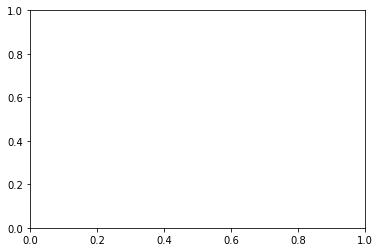

In [46]:
plt.plot(t, I_ext(t))
plt.show()